# Load Data

- https://www.kaggle.com/datasets/tariq9mehmood9/eeg-visual-classification?select=imagenet_class_labels.txt

In [1]:
import torch
import torch.nn as nn

In [2]:
eeg_path = 'data/eeg_signals_raw_with_mean_std.pth'
captions_path = 'data/captions_data.pth'
block_path = 'data/block_splits_by_image_all.pth'


In [4]:
eeg_path = torch.load(eeg_path)
captions_torch = torch.load(captions_path)
block_path = torch.load(block_path)

In [27]:
len(captions_torch['captions'])

1996

In [45]:
eeg_path['dataset'][0]['eeg'].shape
# 128 channel, sampling rate 250?
# There is no specific information, so it is difficult to do feature extraction such as FFT, PSD

torch.Size([128, 500])

In [46]:
import matplotlib.pyplot as plt

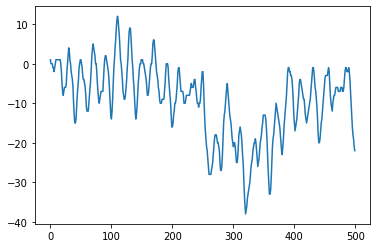

In [49]:
plt.plot(eeg_path['dataset'][0]['eeg'][3])

In [53]:
images = []
labels = []
subjects = []
for data in eeg_path['dataset']:
    images.append(data['image'])
    labels.append(data['label'])
    subjects.append(data['subject'])


<AxesSubplot:xlabel='label', ylabel='count'>

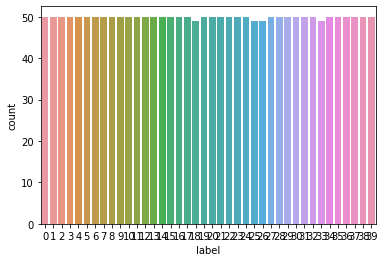

In [107]:
import pandas as pd
import seaborn as sns

users_df = pd.DataFrame({'image' : images, 'label' : labels, 'subject' : subjects})
user_df = users_df[users_df['subject'] == 4]

sns.countplot(data=user_df, x='label')
# count of ['image'] is same as imagenet_class_labels
# (Assumption) ['image'] is same as those are written imagenet_class_labels 
# (Assumption) ['label'] is group of similar ['image']s

In [124]:
images_in_label = user_df[user_df['label'] == 1]['image'].values

In [125]:
images_in_label


array([  38,  102,  116,  243,  246,  264,  317,  318,  327,  335,  352,
        357,  360,  369,  382,  415,  428,  522,  538,  542,  564,  604,
        716,  724,  820,  825,  862,  914,  972, 1052, 1071, 1203, 1236,
       1322, 1446, 1451, 1455, 1480, 1529, 1621, 1647, 1694, 1715, 1744,
       1771, 1800, 1819, 1856, 1907, 1963])

In [106]:
images_in_label

array([  19,   25,  164,  200,  222,  376,  434,  446,  477,  484,  507,
        510,  680,  700,  758,  766,  831,  832,  880,  928,  975,  986,
        998, 1073, 1111, 1142, 1154, 1159, 1196, 1223, 1368, 1378, 1392,
       1430, 1484, 1517, 1630, 1657, 1676, 1688, 1703, 1786, 1822, 1854,
       1884, 1895, 1897, 1923, 1987, 1988])

In [134]:
captions_torch['captions'][318]

'A couple of people standing on top of a grass covered field.'

# Key Informations
- label : total 40(0~39)
- subjects : total 6
- images : total 1996 and each 50 similar images make the same group(label)
- eeg : (maybe) 128 channel and 250 or 500Hz

# First step : Can we distinguish each label through EEG?
- Approach 1 : with machine learning
- Approach 2 : with deep learning

# Approach2 - EEGNet

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [54]:
eeg_signals = []
labels = []

num_subject = 3

for entry in eeg_path['dataset']:
    if entry['subject'] == num_subject:
        eeg_signals.append(entry['eeg'][:, 64:320])
        labels.append(entry['label'])

X = torch.stack(eeg_signals)
y = torch.tensor(labels)

In [48]:
class EEGNet(nn.Module):
    def __init__(self, num_classes=40):
        super(EEGNet, self).__init__()

        # temporal convolution
        self.conv1 = nn.Conv2d(1, 8, (1,64), padding=(0, 32), bias=False)
        self.batch_norm1 = nn.BatchNorm2d(8)

        # depthwise convolution
        self.depthwise_conv = nn.Conv2d(8, 16, (128, 1), groups=8, bias=False)
        self.batch_norm2 = nn.BatchNorm2d(16)
        self.elu = nn.ELU()
        self.avg_pool1 = nn.AvgPool2d((1,4))
        self.drpout1 = nn.Dropout(0.25)

        # separable convolution
        self.separable_conv = nn.Conv2d(16, 16, (1,16), padding=(0, 8), bias=False)
        self.batch_norm3 = nn.BatchNorm2d(16)
        self.avg_pool2 = nn.AvgPool2d((1, 8))
        self.dropout2 = nn.Dropout(0.25)

        # FC layer
        self.fc = nn.Linear(16 * 256 // 32, num_classes) # adjust dimensions

    def forward(self, x):
        x = self.conv1(x)
        x = self.batch_norm1(x)
        
        x = self.depthwise_conv(x)
        x = self.batch_norm2(x)
        x = self.elu(x)
        x = self.avg_pool1(x)
        x = self.drpout1(x)
        
        x = self.separable_conv(x)
        x = self.batch_norm3(x)
        x = self.avg_pool2(x)
        x = self.dropout2(x)

        x = x.view(x.size(0), -1) # flatten
        x = self.fc(x)

        return x
        

In [55]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

X_train = X_train.unsqueeze(1)
X_valid = X_valid.unsqueeze(1)

X_train = X_train.float()
X_valid = X_valid.float()


print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_valid:", X_valid.shape)
print("Shape of y_valid:", y_valid.shape)

print("Data type of X_train:", X_train.dtype) 
print("Data type of X_valid:", X_valid.dtype) 

Shape of X_train: torch.Size([1596, 1, 128, 256])
Shape of y_train: torch.Size([1596])
Shape of X_valid: torch.Size([400, 1, 128, 256])
Shape of y_valid: torch.Size([400])
Data type of X_train: torch.float32
Data type of X_valid: torch.float32


In [56]:
dataset = TensorDataset(X_train, y_train)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [57]:
model = EEGNet(num_classes=40)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [58]:
for epoch in range(10):
    model.train()
    for batch in dataloader:
        inputs, labels = batch
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch + 1}, Loss : {loss.item()}')

Epoch 1, Loss : 2.7425734996795654
Epoch 2, Loss : 1.9903556108474731
Epoch 3, Loss : 1.2148157358169556
Epoch 4, Loss : 1.0325723886489868
Epoch 5, Loss : 0.5596059560775757
Epoch 6, Loss : 0.4458475708961487
Epoch 7, Loss : 0.29045623540878296
Epoch 8, Loss : 0.2957540452480316
Epoch 9, Loss : 0.2843899130821228
Epoch 10, Loss : 0.07915980368852615


In [59]:
model.eval()

total_loss = 0.0
correct_predicctions = 0

with torch.no_grad():
    for i in range(len(X_valid)):
        inputs = X_valid[i].unsqueeze(0)
        labels = y_valid[i].unsqueeze(0)

        outputs = model(inputs)

        loss = criterion(outputs, labels)
        total_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        if predicted.item() == labels.item():
            correct_predicctions += 1

average_loss = total_loss / len(X_valid)
accuracy = correct_predicctions / len(X_valid)

print(f"Validation Loss: {average_loss:.4f}")
print(f"Validation Accuracy: {accuracy * 100:.2f}%")

Validation Loss: 0.1085
Validation Accuracy: 99.25%
